In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
results_dir = Path.cwd().parent / "results" / "samples"

# Save Results

## Load mlflow runs

In [2]:
results_dir = Path.cwd().parent / "results" / "samples"
os.makedirs(results_dir, exist_ok=True)

In [3]:
db_port = 5001
db_name = 'cohirf'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()


In [4]:
experiment_names

['Default',
 'sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-BatchCoHiRF-SC-SRGF',
 'sfni-BatchCoHiRF-1iter',
 'sfni-CoHiRF',
 'sphere-BatchCoHiRF-DBSCAN-1iter',
 'sphere-DBSCAN',
 'sphere-CoHiRF-DBSCAN',
 'real-ari-BatchCoHiRF-1iter',
 'real-ari-AverageAgglomerativeClustering',
 'real-ari-BatchCoHiRF-DBSCAN-1iter',
 'real-ari-AffinityPropagation',
 'real-ari-BatchCoHiRF-SC-SRGF',
 'real-ari-CoHiRF-DBSCAN',
 'real-ari-CoHiRF-KernelRBF',
 'real-ari-CoHiRF',
 'real-ari-CompleteAgglomerativeClustering',
 'real-ari-DBSCAN',
 'real-ari-HDBSCAN',
 'real-ari-IRFLLRR',
 'real-ari-KMeans',
 'real-ari-MeanShift',
 'real-ari-OPTICS',
 'real-ari-Proclus',
 'real-ari-SingleAgglomerativeClustering',
 'real-ari-SpectralClustering',
 'real-ari-SpectralSubspaceRandomization',
 'real-ari-WardAgglomerativeClustering',
 'real-adjusted_mutual_info-BatchCoHiRF-DBSCAN-1iter',
 'real-adjusted_mutual_info-DBSCAN',
 'real-adjusted_mutual_info-BatchCoHiRF-SC-SRGF',
 'real-adjusted_mutual_info-Comple

In [5]:
experiments_names = [exp for exp in experiment_names if exp.startswith("scale_samples-")]

In [6]:
experiments_names

['scale_samples-BatchCoHiRF-1iter',
 'scale_samples-CoHiRF',
 'scale_samples-BatchCoHiRF-SC-SRGF',
 'scale_samples-SpectralSubspaceRandomization',
 'scale_samples-KMeans',
 'scale_samples-BatchCoHiRF-SC-SRGF-1R-1iter-random']

In [7]:
params_columns = [
    "model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_informative",
    "n_random",
    "n_classes",
    "class_sep",
    "best/child_run_id",
]

In [8]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best/n_clusters_',
    'best/rand_score',
    'best/adjusted_rand',
    'best/mutual_info',
    'best/adjusted_mutual_info',
    'best/normalized_mutual_info',
    'best/homogeneity_completeness_v_measure',
    'best/silhouette',
    'best/calinski_harabasz_score',
    'best/davies_bouldin_score',
    'best/inertia_score',
    'best/homogeneity',
    'best/completeness',
    'best/v_measure',
	'best/elapsed_time',
]

In [9]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'mlflow.parentRunId',
]

In [10]:
# # parameters of each model, they are saved as tags for the parent run
# parameters = {
#     'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
#     'KMeans': ['n_clusters'],
#     'HDBSCAN': ['min_cluster_size'],
#     'DBSCAN': ['eps', 'min_samples'],
#     'AffinityPropagation': ['damping'],
#     'OPTICS': ['min_samples'],
#     'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
#     'WardAgglomerativeClustering': ['n_clusters'],
# }
# all_model_parameters = [p for model, params in parameters.items() for p in params]
# all_model_parameters = list(set(all_model_parameters))
# for param in all_model_parameters:
#     tags_columns.append(param)

In [11]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [12]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)
df_runs_raw.to_csv(results_dir / 'df_runs_raw.csv', index=True)

In [13]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw.csv", index_col=0)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['mlflow.parentRunId'].isna()]

In [14]:
df_runs_raw_parents

,status,start_time,end_time,best/child_run_id,class_sep,model,n_classes,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,v_measure,EXCEPTION,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
011fe0dbb8954a43a7124f9fddda010a,RUNNING,1753013192325,NaN,NaN,9.486833,BatchCoHiRF-1iter,5,10,10000,100000,...,NaN,1.609438,227.0,0.537320,0.820278,-0.006004,0.537320,NaN,NaN,NaN
01afa65e9cc8432f9c2a625f0a12d3e0,FINISHED,1752574586269,1.752575e+12,22470dfa78904840b6174940865418d1,9.486833,KMeans,5,10,10000,10000,...,2804.608,1.609438,9.0,0.887344,0.949494,0.009871,0.887344,NaN,NaN,False
02649621c0264b07bdbb1d7521e26f25,RUNNING,1767807923330,NaN,NaN,9.486833,BatchCoHiRF-SC-SRGF-1R-1iter-random,5,10,10000,100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02845fdf7b884609b592e500649692dc,FINISHED,1767807902227,1.767811e+12,beabeb0465e34c038940a4929c14ddba,9.486833,BatchCoHiRF-SC-SRGF-1R-1iter-random,5,10,10000,10000,...,2684.896,0.140447,2.0,0.139268,0.374420,0.008788,0.139268,NaN,NaN,False
03288a0d730e4303bdb4dd4ad6021f6a,FAILED,1767811082162,1.767811e+12,NaN,9.486833,BatchCoHiRF-SC-SRGF-1R-1iter-random,5,10,10000,10000000,...,337.840,NaN,NaN,NaN,NaN,NaN,NaN,Unable to allocate 746. GiB for an array with ...,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f8cfb8092f7b4ceeb531c9d0b14cbb92,FINISHED,1753240373001,1.753241e+12,f954815382b14fe68ff6a78e75613805,9.486833,KMeans,5,10,10000,100000,...,23882.652,1.609438,12.0,0.807117,0.903918,0.006986,0.807117,NaN,NaN,False
fa116dec111a4feda8c961e99bad005e,RUNNING,1753010964446,NaN,NaN,9.486833,KMeans,5,10,10000,100000,...,NaN,1.609438,20.0,0.708739,0.855878,-0.000258,0.708739,NaN,NaN,NaN
faf5dbc06d9a4d99ae2b8be823f91300,FINISHED,1752574472685,1.752575e+12,94ba39b3a02a490a8ed848d8ee60e25a,9.486833,CoHiRF,5,10,10000,100,...,399.364,1.054920,3.0,0.791876,0.838384,0.028476,0.791876,NaN,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [15]:
non_duplicate_columns = [
    "model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_classes",
    "class_sep",
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best/adjusted_rand"]).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")

# Missing

In [16]:
model_nickname = df_runs_parents['model'].unique().tolist()
model_nickname.sort()
model_nickname

['BatchCoHiRF-1iter',
 'BatchCoHiRF-SC-SRGF',
 'BatchCoHiRF-SC-SRGF-1R-1iter-random',
 'CoHiRF',
 'KMeans',
 'SpectralSubspaceRandomization']

In [17]:
model_nickname = [
    # "BatchCoHiRF-1iter",
    # "BatchCoHiRF-SC-SRGF",
    # "CoHiRF",
    "KMeans",
    # "SpectralSubspaceRandomization",
    "BatchCoHiRF-SC-SRGF-1R-1iter-random",
]

In [18]:
non_duplicate_columns = [
    "model",
    # "seed_model",
    "n_samples",
    "seed_dataset",
    # "n_random",
    # "n_informative",
    # "n_classes",
    # "class_sep",
]

In [29]:
n_samples = [100, 1000, 10000, 100000]#, 1000000, 10000000]  # , 200000]
seed_dataset = [i for i in range(5)]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, seed_dataset]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [30]:
df_missing

,model,n_samples,seed_dataset
0,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,0
1,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,1
2,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,3
3,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,4
4,BatchCoHiRF-SC-SRGF-1R-1iter-random,1000,0
5,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,0
6,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,1
7,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,2
8,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,3
9,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,4


In [31]:
df_missing["hpo_seed"] = df_missing["seed_dataset"]

In [32]:
df_missing.to_csv(results_dir / 'df_missing.csv', index=False)

In [33]:
# Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
df_missing_with_exception = df_missing.merge(
    df_runs_raw_parents[non_duplicate_columns + ["raised_exception"]],
    how="left",
    left_on=["model", "n_samples", "seed_dataset"],
    right_on=["model", "n_samples", "seed_dataset"],
)
df_missing_with_exception[["model", "n_samples", "seed_dataset", "raised_exception"]]

,model,n_samples,seed_dataset,raised_exception
0,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,0,NaN
1,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,1,NaN
2,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,3,NaN
3,BatchCoHiRF-SC-SRGF-1R-1iter-random,100,4,NaN
4,BatchCoHiRF-SC-SRGF-1R-1iter-random,1000,0,NaN
5,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,0,NaN
6,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,1,NaN
7,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,2,NaN
8,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,3,NaN
9,BatchCoHiRF-SC-SRGF-1R-1iter-random,100000,4,NaN


In [34]:
results_dir

PosixPath('/home/belucci/code/cohirf/results/samples')

In [35]:
missing_dict = {}
for model in df_missing['model'].unique():
    sub = df_missing[df_missing["model"] == model].drop(columns=["model"])
    missing_dict[model] = sub.to_dict(orient="records")
if len(missing_dict) != 0:
    with open(results_dir / 'missing_dict.pkl', 'wb') as f:
        pickle.dump(missing_dict, f)

# Get common combinations

In [13]:
model_nickname = [
	"BatchCoHiRF-1iter",
	"BatchCoHiRF-SC-SRGF",
	"CoHiRF",
	"KMeans", 
	"SpectralSubspaceRandomization"
]
df = df_runs_parents.copy()
df = df.loc[df["model"].isin(model_nickname)]
column = 'model'
combination_columns = [
    "n_samples",
    "seed_dataset",
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [14]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [15]:
model_nickname = [
	"BatchCoHiRF-1iter",
	"BatchCoHiRF-SC-SRGF",
	"CoHiRF",
	"KMeans", 
	"SpectralSubspaceRandomization"
]
df = df_runs_parents.copy()
df = df.loc[df["model"].isin(model_nickname)]
df = df.loc[df["n_samples"] == 200000]
column = 'model'
combination_columns = [
    "n_samples",
    "seed_dataset",
]
common_combinations = get_common_combinations(df, column, combination_columns)
df_common2 = get_df_with_combinations(df, combination_columns, common_combinations)

TypeError: unbound method set.intersection() needs an argument

In [27]:
df_common = pd.concat([df_common, df_common2], ignore_index=True)

NameError: name 'df_common2' is not defined

# Plots

In [24]:
3*(10**0.5)*2

18.973665961010276

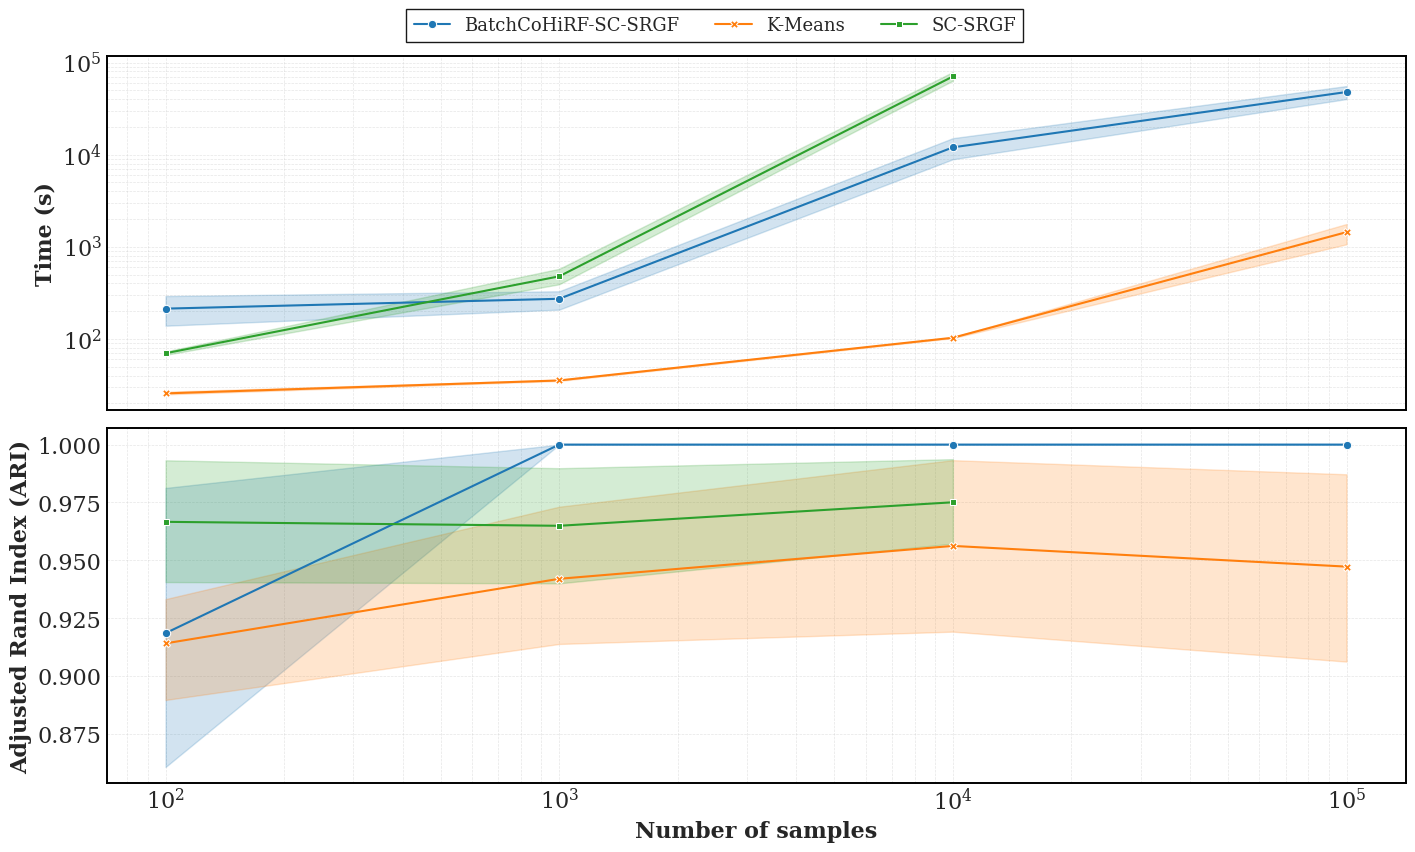

In [31]:
df = df_runs_parents.copy()
n_classes = 5
n_informative = 10
n_non_informative = 10000
class_sep = 3 * (n_informative**0.5)
models_names = {
	# "BatchCoHiRF-1iter": "Batch CoHiRF",
	"BatchCoHiRF-SC-SRGF": "BatchCoHiRF-SC-SRGF",
	# "CoHiRF": "CoHiRF",
	"KMeans": "K-Means", 
	"SpectralSubspaceRandomization": "SC-SRGF"
}
df = df.loc[df["model"].isin(models_names.keys())]
df = df.loc[df["n_classes"] == n_classes]
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_random"] == n_non_informative]
df = df.loc[df["class_sep"] == class_sep]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
	columns={
		"fit_model_return_elapsed_time": "Time (s)",
		"max_memory_used": "Memory (MB)",
		"n_samples": "Number of samples",
		"model": "Model",
		"best/adjusted_rand": "ARI",
	}
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "font.family": "serif",
        "font.serif": ["DejaVu Serif", "Liberation Serif", "Times", "serif"],  # Reliable serif fonts
        "mathtext.fontset": "dejavuserif",  # Use DejaVu for math text to avoid missing glyphs
        "axes.unicode_minus": False,  # Use ASCII minus instead of Unicode minus
        "font.size": 12,
        "axes.linewidth": 1.2,
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 10,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.shadow": False,
        "legend.framealpha": 0.9,
        "legend.edgecolor": "black",
        "grid.alpha": 0.5,
        "axes.grid": True,
        "grid.linewidth": 0.5,
    }
):
    cm = 1 / 2.54  # centimeters to inches
    scale = 3.0
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12 * scale * cm, 7 * scale * cm))
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
		data=df,
		x="Number of samples",
		y="Time (s)",
		hue="Model",
		style="Model",
		markers=True,
		dashes=False,
		errorbar="ci",
		ax=axs[0],
		palette=palette,
	)
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)", fontweight='bold')
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
		data=df,
		x="Number of samples",
		y="ARI",
		hue="Model",
		style="Model",
		markers=True,
		dashes=False,
		errorbar="ci",
		ax=axs[1],
		palette=palette,
	)
    ax2.set_xscale("log")
    ax2.set_ylabel("Adjusted Rand Index (ARI)", fontweight='bold')
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    for spine in ["left", "right", "top", "bottom"]:
        ax2.spines[spine].set_linewidth(1.4)
        ax2.spines[spine].set_color("black")
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=True, bbox_to_anchor=(0.5, 1.04))
    ax.get_legend().remove()
    for spine in ["left", "right", "top", "bottom"]:
        ax.spines[spine].set_linewidth(1.4)
        ax.spines[spine].set_color("black")
    ax2.get_legend().remove()
    plt.xlabel("Number of samples", fontweight='bold')
    plt.tight_layout()
    plt.savefig(
        results_dir
        / f"hpo_hypercube_samples_n_classes_{n_classes}_n_informative_{n_informative}_n_non_informative_{n_non_informative}_class_sep_{class_sep}.pdf",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

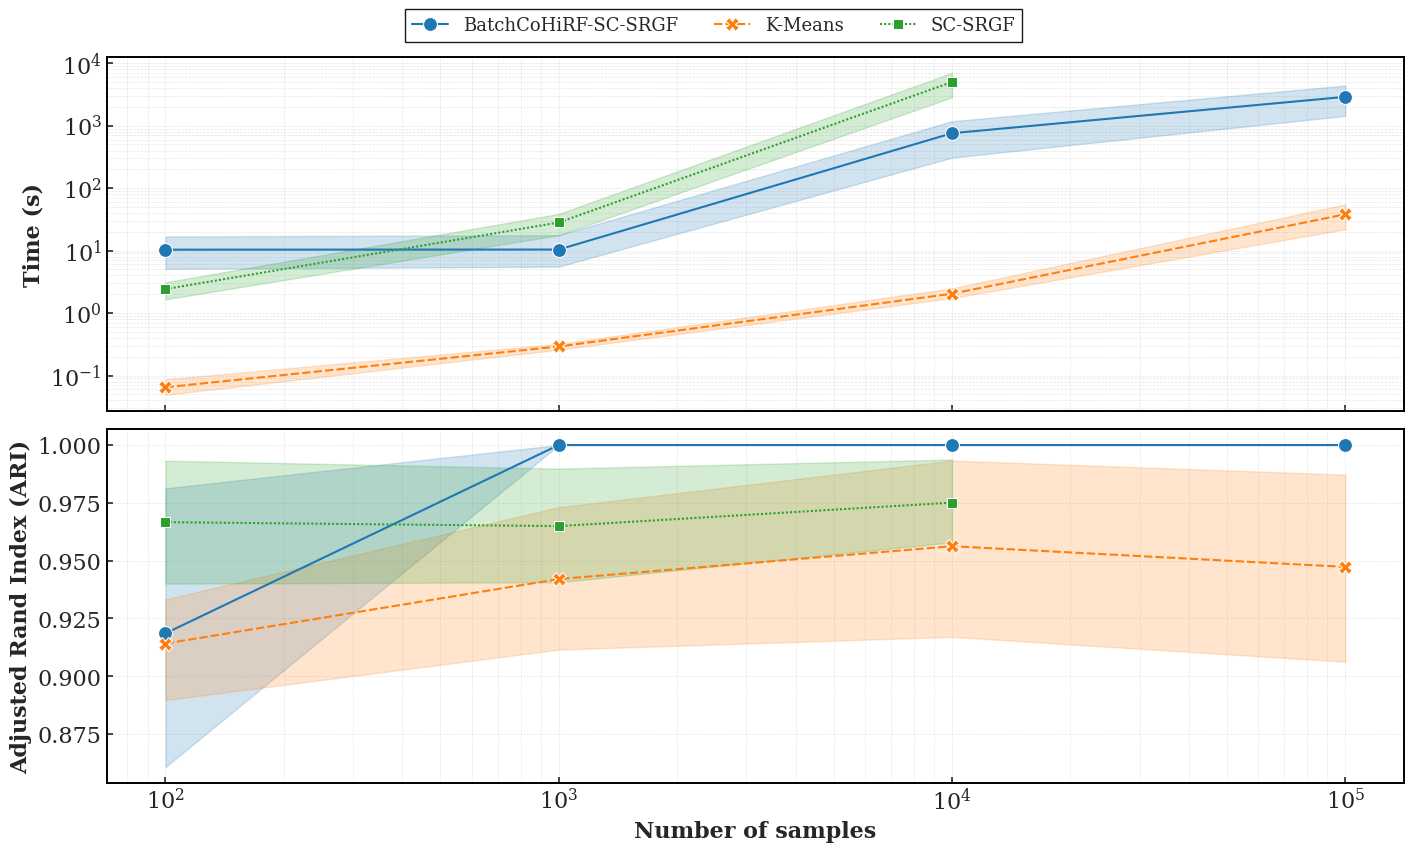

In [ ]:
df = df_runs_parents.copy()
n_classes = 5
n_informative = 10
n_non_informative = 10000
class_sep = 3 * (n_informative**0.5)
models_names = {
    # "BatchCoHiRF-1iter": "Batch CoHiRF",
    "BatchCoHiRF-SC-SRGF": "BatchCoHiRF-SC-SRGF",
    # "CoHiRF": "CoHiRF",
    "KMeans": "K-Means",
    "SpectralSubspaceRandomization": "SC-SRGF",
}
df = df.loc[df["model"].isin(models_names.keys())]
df = df.loc[df["n_classes"] == n_classes]
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_random"] == n_non_informative]
df = df.loc[df["class_sep"] == class_sep]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "best/elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "font.family": "serif",
        "font.serif": ["DejaVu Serif", "Liberation Serif", "Times", "serif"],  # Reliable serif fonts
        "mathtext.fontset": "dejavuserif",  # Use DejaVu for math text to avoid missing glyphs
        "axes.unicode_minus": False,  # Use ASCII minus instead of Unicode minus
        "font.size": 12,
        "axes.linewidth": 1.2,
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 10,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.shadow": False,
        "legend.framealpha": 0.9,
        "legend.edgecolor": "black",
        "grid.alpha": 0.5,
        "axes.grid": True,
        "grid.linewidth": 0.5,
    }
):
    cm = 1 / 2.54  # centimeters to inches
    scale = 3.0
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12 * scale * cm, 7 * scale * cm))
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of samples",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        markersize=10,
        # dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)", fontweight="bold")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of samples",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        markersize=10,
        # dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_xscale("log")
    ax2.set_ylabel("Adjusted Rand Index (ARI)", fontweight="bold")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    for spine in ["left", "right", "top", "bottom"]:
        ax2.spines[spine].set_linewidth(1.4)
        ax2.spines[spine].set_color("black")
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=True, bbox_to_anchor=(0.5, 1.04))
    ax.get_legend().remove()
    ax.tick_params(direction="in", length=4, width=1.2)
    ax2.tick_params(direction="in", length=4, width=1.2)
    for spine in ["left", "right", "top", "bottom"]:
        ax.spines[spine].set_linewidth(1.4)
        ax.spines[spine].set_color("black")
    ax2.get_legend().remove()
    plt.xlabel("Number of samples", fontweight="bold")
    plt.tight_layout()
    plt.savefig(
        results_dir
        / f"best_hypercube_samples_n_classes_{n_classes}_n_informative_{n_informative}_n_non_informative_{n_non_informative}_class_sep_{class_sep}.pdf",
        dpi=300,
        bbox_inches='tight',
    )
    plt.show()

/tmp/ipykernel_26553/92922456.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


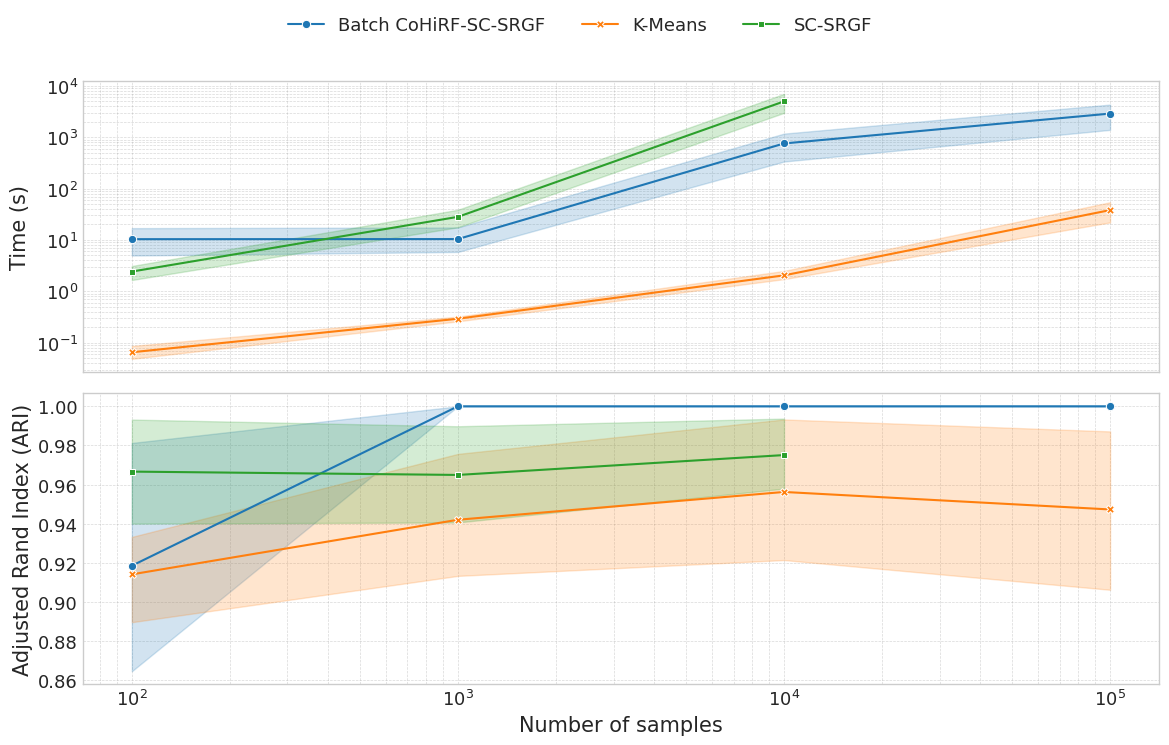

In [24]:
df = df_runs_parents.copy()
models_names = {
    # "BatchCoHiRF-1iter": "Batch CoHiRF",
    "BatchCoHiRF-SC-SRGF": "Batch CoHiRF-SC-SRGF",
    # "CoHiRF": "CoHiRF",
    "KMeans": "K-Means",
    "SpectralSubspaceRandomization": "SC-SRGF",
}
df = df.loc[df["model"].isin(models_names.keys())]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "best/elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of samples",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of samples",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_xscale("log")
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of samples")
    plt.tight_layout()
    plt.savefig(
        results_dir
        / f"best_hypercube_samples_n_classes_{n_classes}_n_informative_{n_informative}_n_non_informative_{n_non_informative}_class_sep_{class_sep}.pdf",
        dpi=300,
    )
    plt.show()

# Debug and explore

In [22]:
df = df_runs_raw.copy()
# df = df.loc[df['model_nickname'].isin(['IRFLLRR', 'Proclus', 'SpectralSubspaceRandomization'])]

In [23]:
runs_to_delete = list(df.index)

In [24]:
print(runs_to_delete, len(runs_to_delete))

['0007d75ba74d46108c24a2f84dcbf8e4', '000aa1c139e84063bb8c72b62c663e04', '0020de9a8ddb4f4bb205652af303c21f', '0051fdb1338c401fb10fcce3bbf1f76c', '005dc019eb1b455c9073634bad661061', '006503c18f5a40c9b6f5138415db598f', '006dc411d9df4c8abc08d0939687cb0a', '008b8b32dcab428abd871eca700bbc07', '009f9bf63cb54404bc3cb9139bc8e5fd', '00e987fcf7ac4dea8e8ae70131a9093e', '00ea900451f043fd8038de0f0830f867', '0107b81032b9424780f7fff1f373703b', '0118f8758035407eae47d5abef4b78a6', '01241e2701f043ce98d7797a5564edb4', '01287578f1e74b1fb0ff0536d67b8dc3', '012e7eab64c24a10802b9b0dd69260fa', '0148b5ba150d488697b22706ecfdd549', '0158bb2319554785ad687f0d7dad67b3', '017161e9300646b79497a5771104b729', '019fb764c08f4d8b9536cfc862bb79e0', '01ad969fc2ec435ba2a33ff1e9f8bd03', '01b9b038f39c4029897ef132d2d41fb6', '01be9f85b3b54025b2ba71cbc33b4bf6', '01c463193b404c3ea7a70cb76140af6f', '01cddc8f9a804c6f94aadc1be386ec02', '01d02c060d2f47448c9cd84a996d0a07', '01da3bc0cc0543d3b71f4f34376a04b6', '01f1d826a12a40f0a4527d3872

In [25]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [26]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [27]:
query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    